In [2]:
import osmnx as ox # Library for open street map to access geographic data
import networkx as nx 
import geopandas as gpd # Library for working with geospatial data

import geohash # Library for encoding geohash identifiers on the road segments

# Bounding boxes for 20007 zip code
zip_code = "20007, Washington, DC, USA"

# Get the road network (graph) for the area
# We only want driving roads wo network_type is drive
G = ox.graph_from_place(zip_code, network_type="drive")

# Convert graph to a GeoDataFrame
nodes, edges = ox.graph_to_gdfs(G)

edges["road_id"] = range(len(edges))

def get_geohash(geometry, precision=7):
    if geometry.geom_type == "LineString": # To check if the input is a road segment otherwise return none
        midpoint = geometry.interpolate(0.5, normalized=True)  # Get the midpoint of the road
        return geohash.encode(midpoint.y, midpoint.x, precision=precision) # Generate a geohash based on the midpoint x and y coord of the road segment
    return None

edges["geohash"] = edges["geometry"].apply(get_geohash) # Apply get_geohash func on all edges into corresponding "geohash"

edges.to_file("road_segments.geojson", driver="GeoJSON")

#print(edges[["road_id", "geohash", "geometry"]].head())


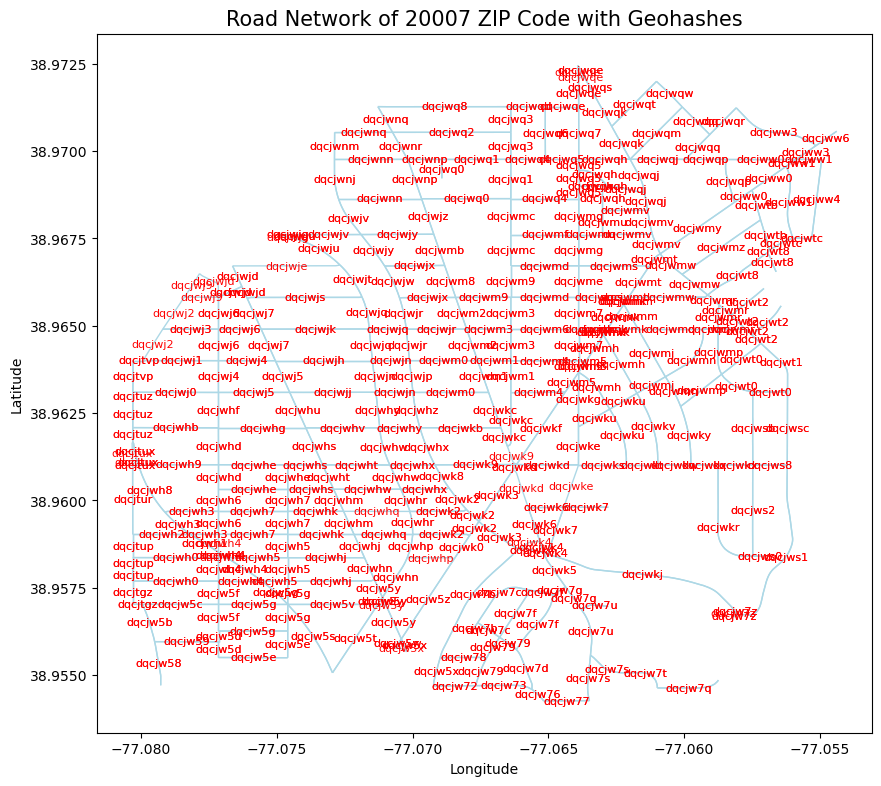

In [3]:
import matplotlib.pyplot as plt

# Plot the road network
fig, ax = plt.subplots(figsize=(10, 10))

edges.plot(ax=ax, color='lightblue', linewidth=1)

for idx, row in edges.iterrows():
    if row['geohash'] is not None:
        midpoint = row['geometry'].interpolate(0.5, normalized=True)
        ax.text(midpoint.x, midpoint.y, row['geohash'], fontsize=8, color='red', ha='center', va='center')

ax.set_title("Road Network of 20007 ZIP Code with Geohashes", fontsize=15)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show() 

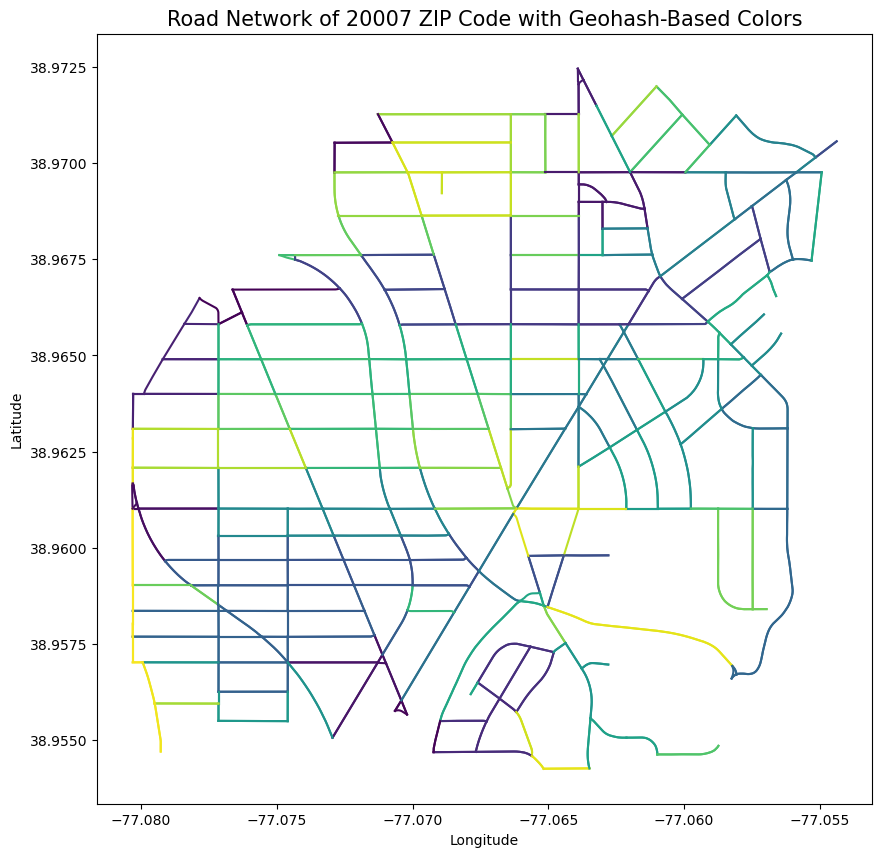

In [4]:
import matplotlib.pyplot as plt

# Generate a unique color for each geohash so we can visualize
unique_geohashes = edges["geohash"].dropna().unique()
color_map = {gh: plt.cm.viridis(i / len(unique_geohashes)) for i, gh in enumerate(unique_geohashes)}

# Assign colors to each road segment based on geohash
edges["color"] = edges["geohash"].map(color_map)

fig, ax = plt.subplots(figsize=(10, 10))

for _, row in edges.iterrows():
    color = row["color"] if row["geohash"] in color_map else "gray"  # Default to gray if no geohash
    ax.plot(*row["geometry"].xy, color=color, linewidth=1.5)

ax.set_title("Road Network of 20007 ZIP Code with Geohash-Based Colors", fontsize=15)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()


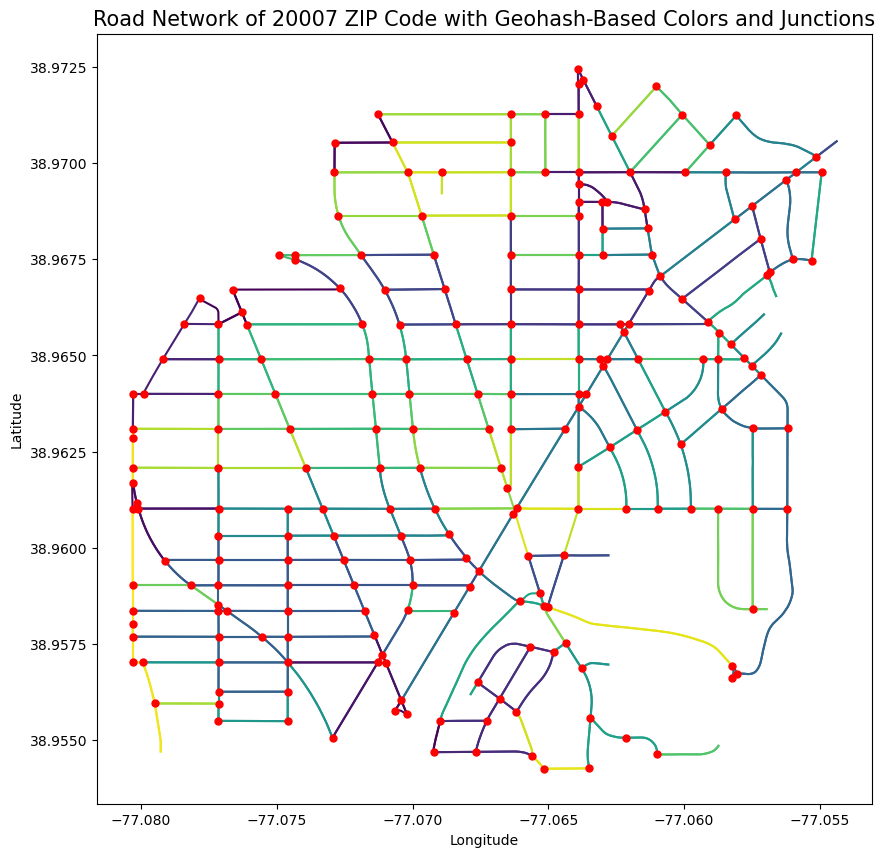

In [5]:
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.ops import unary_union

# Generate a unique color for each geohash so we can visualize
unique_geohashes = edges["geohash"].dropna().unique()
color_map = {gh: plt.cm.viridis(i / len(unique_geohashes)) for i, gh in enumerate(unique_geohashes)}

# Assign colors to each road segment based on geohash
edges["color"] = edges["geohash"].map(color_map)

# Find the intersection points (junctions)
junctions = [] #Initialize a empty list to store all junction points
# For each road segment we will iterate through all road segments to see if they intersect
for i, row1 in edges.iterrows():
    for j, row2 in edges.iterrows():
        # Skip comparing the same road segment
        if i >= j:
            continue
        # Check if the two segments intersect
        if row1["geometry"].intersects(row2["geometry"]):
            intersection = row1["geometry"].intersection(row2["geometry"])
            if intersection.is_empty:
                continue
            # If the intersection is a point, add it to the junctions list
            if isinstance(intersection, Point):
                junctions.append((intersection.x, intersection.y))
            # If the intersection is a multi-point, add all points
            elif intersection.geom_type == 'MultiPoint':
                for point in intersection:
                    junctions.append((point.x, point.y))

# Remove duplicates by converting to a set of tuples
junctions = list(set(junctions))

# Plot the road network and junctions
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the road network
for _, row in edges.iterrows():
    color = row["color"] if row["geohash"] in color_map else "gray"  # Default to gray if no geohash
    ax.plot(*row["geometry"].xy, color=color, linewidth=1.5)

# Plot the junctions as red dots
for (x, y) in junctions:
    ax.plot(x, y, 'ro', markersize=5)  # 'ro' stands for red circles

ax.set_title("Road Network of 20007 ZIP Code with Geohash-Based Colors and Junctions", fontsize=15)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()


In [ ]:
# Bounding box for 20007 zip code
zip_code = "20007, Washington, DC, USA"

# Get the polygon of the ZIP code
zip_code_polygon = ox.geocode_to_gdf(zip_code).geometry.iloc[0]

# Expand the bounding box by creating a buffer around the ZIP code
buffer_distance = 100  # Buffer distance in meters (can adjust this)
expanded_polygon = zip_code_polygon.buffer(buffer_distance)


# Get the road network (graph) for the expanded area using the enlarged boundary
G = ox.graph_from_polygon(expanded_polygon, network_type="drive")

# Convert the graph to GeoDataFrames (nodes and edges)
nodes, edges = ox.graph_to_gdfs(G)

# Add a unique road ID
edges["road_id"] = range(len(edges))

# Function to encode geohash
def get_geohash(geometry, precision=7):
    if geometry.geom_type == "LineString":  # Only for road segments
        midpoint = geometry.interpolate(0.5, normalized=True)  # Midpoint of the road segment
        return geohash.encode(midpoint.y, midpoint.x, precision=precision)  # Encode the midpoint's lat/lon to geohash
    return None

# Apply geohash encoding on each road segment
edges["geohash"] = edges["geometry"].apply(get_geohash)

# Save the road network to a GeoJSON file
edges.to_file("expanded_road_segments.geojson", driver="GeoJSON")

# Optional: Print a preview of the edges data
print(edges[["road_id", "geohash", "geometry"]].head())



zip_code = "20007, Washington, DC, USA"

# Get the road network (graph) for the area
# We only want driving roads wo network_type is drive
G = ox.graph_from_place(zip_code, network_type="drive")

# Convert graph to a GeoDataFrame
nodes, edges = ox.graph_to_gdfs(G)

edges["road_id"] = range(len(edges))

def get_geohash(geometry, precision=7):
    if geometry.geom_type == "LineString": # To check if the input is a road segment otherwise return none
        midpoint = geometry.interpolate(0.5, normalized=True)  # Get the midpoint of the road
        return geohash.encode(midpoint.y, midpoint.x, precision=precision) # Generate a geohash based on the midpoint x and y coord of the road segment
    return None

edges["geohash"] = edges["geometry"].apply(get_geohash) # Apply get_geohash func on all edges into corresponding "geohash"

edges.to_file("road_segments.geojson", driver="GeoJSON")

c:\Users\theod\miniconda3\envs\test_env\lib\site-packages\osmnx\_overpass.py:267: UserWarning: This area is 244,766 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


Next, I want to create a map of our region of interest using Mobile Coverage Data


First need to write a automation script to fetch the necessary data


In [ ]:
import requests
from bs4 import BeautifulSoup

url = "https://www.cellmapper.net/map?MCC=310&MNC=260&type=NR&latitude=38.8957&longitude=-77.0461&zoom=15"

# Send HTTP request
response = requests.get(url)

# Parse HTML response
soup = BeautifulSoup(response.text, "html.parser")

# Find the data you need from the HTML (this is just an example)
# Find all instances of data embedded in the page
data = soup.find_all("script", {"type": "application/json"})  # Find JSON data in scripts

for script in data:
    print(script.get_text())


TypeError: __init__() got an unexpected keyword argument 'executable_path'